## Interpolation Examples With Peacasso

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/victordibia/peacasso/blob/master/notebooks/interpolation.ipynb)

Peacasso is a library (backend api and UI) for interacting with diffusion models. It is built on the huggingface diffusers library and will work with diffusion models hosted on 

## Requirements and Installation

- Step 1: **Verify Environment - Pythong 3.7+ and CUDA**
  Setup and verify that your python environment is `python 3.7` or higher (preferably, use Conda). Also verify that you have CUDA installed correctly (`torch.cuda.is_available()` is true) and your GPU has about [7GB of VRAM memory](https://stability.ai/blog/stable-diffusion-public-release).

Once requirements are met, run the following command to install the library:

```bash
pip install peacasso
```

In [1]:
# uncomment line below and run to install peacasso!
# %pip install peacasso 

In [2]:
import os
from peacasso.generator import ImageGenerator
from peacasso.datamodel import GeneratorConfig, ModelConfig
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# helper function to plot images
def plot_images(images, title=""):
  plt.figure(figsize=(18,10))
  plt.imshow(images);
  plt.title(title)
  plt.axis('off');
  plt.tight_layout()
  
# helper function to resize an image
def resize_image(image:Image, width:int = 1024): 
  """Resize image to a given width while keeping the aspect ratio"""
  wpercent = (width/float(image.size[0]))
  hsize = int((float(image.size[1])*float(wpercent)))
  return image.resize((width,hsize))

def stack_images(all_images, num_cols=5, resize=1024):
  image_rows = []
  for i in range(0, len(all_images), num_cols):
      image_rows.append(np.concatenate(all_images[i:i+num_cols], axis=1))
  all_images = Image.fromarray(np.asarray(np.concatenate(image_rows, axis=0)))
  all_images = resize_image(all_images, resize)
  return all_images

def process_results(images, width=1024, num_cols=5):
    all_images =[]
    for row in images:
        all_images.extend(row["images"])
    all_images =  stack_images(all_images,num_cols=num_cols, resize=width) 
    return all_images

In [3]:
# model configuration 
model_config: ModelConfig = ModelConfig(
    device="cuda:0" , # device ..cpu, cuda, cuda:0
    model="nitrosocke/mo-di-diffusion",
    revision="main", # HF model branch
    token=None, # HF_TOKEN here if needed
) 
# create a generator object
gen = ImageGenerator(model_config)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

## Interpolation

`Peacasso` supports interpolation (latent interpolation and text embedding interpolation) using the `application` field in `GenerationConfig`.

- Latent Interpolation - Note that latent could be based on `seed` or `image` or `masks`. All supported.
- Text Embedding Interpolation

100%|███████████████████████████| 20/20 [00:28<00:00,  1.40s/it]


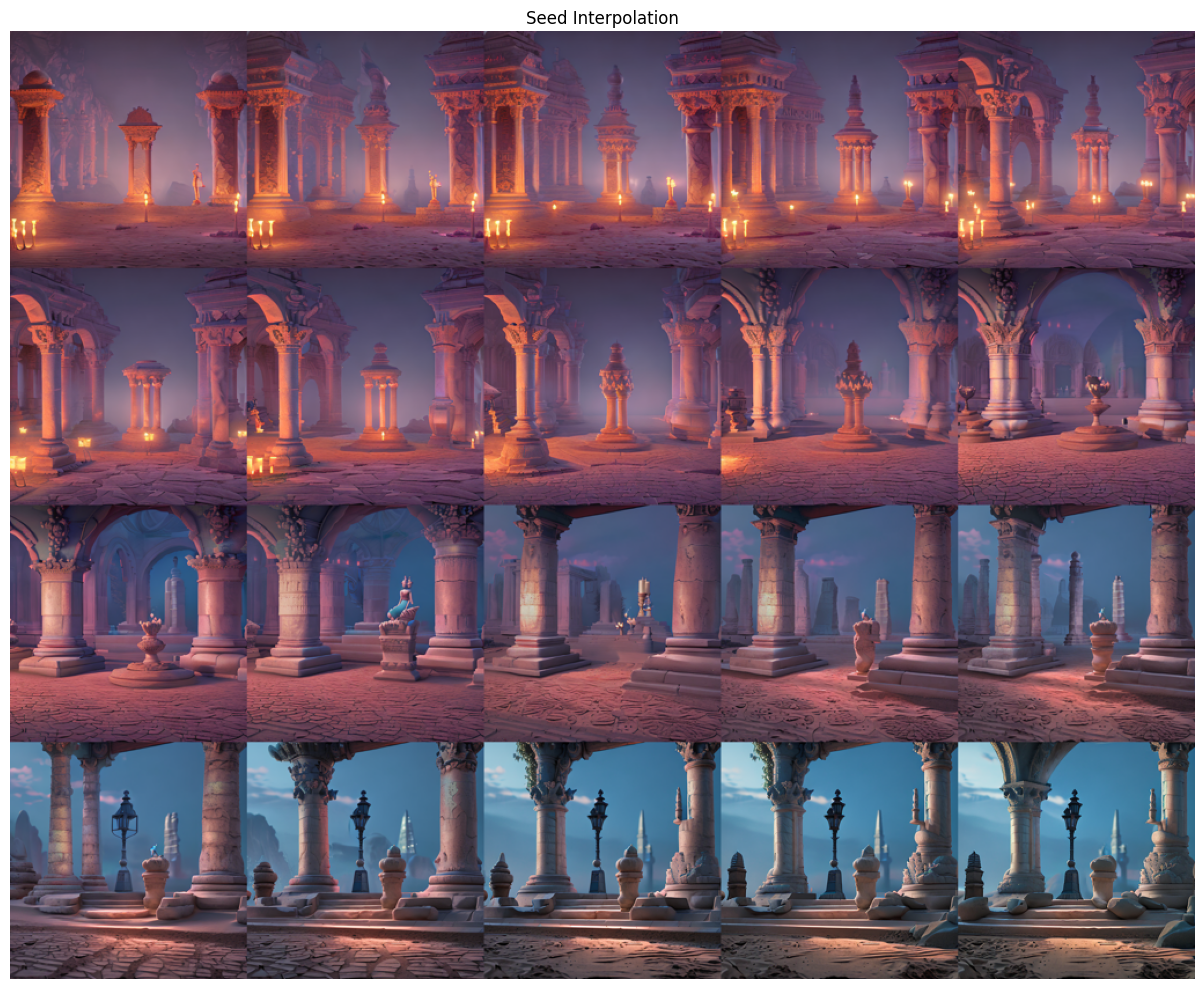

In [4]:
prompt = "victorian ampitheater of sand, pillars with statues on top, lamps on ground, by peter mohrbacher dan mumford craig mullins nekro, cgsociety, pixiv, volumetric light, 3 d render"
interpolation_config = GeneratorConfig(
    prompt=prompt,
    num_images=1,
    num_inference_steps=20, 
    application={
        "type": "interpolate",
        "config": {"num_steps": 20, 
        "seed": {"start": 2045, "end":100034} 
        }
    })
interpolation_results = gen.generate(interpolation_config)  
interpolation_results = process_results(interpolation_results)
plot_images(interpolation_results, title="Seed Interpolation")


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

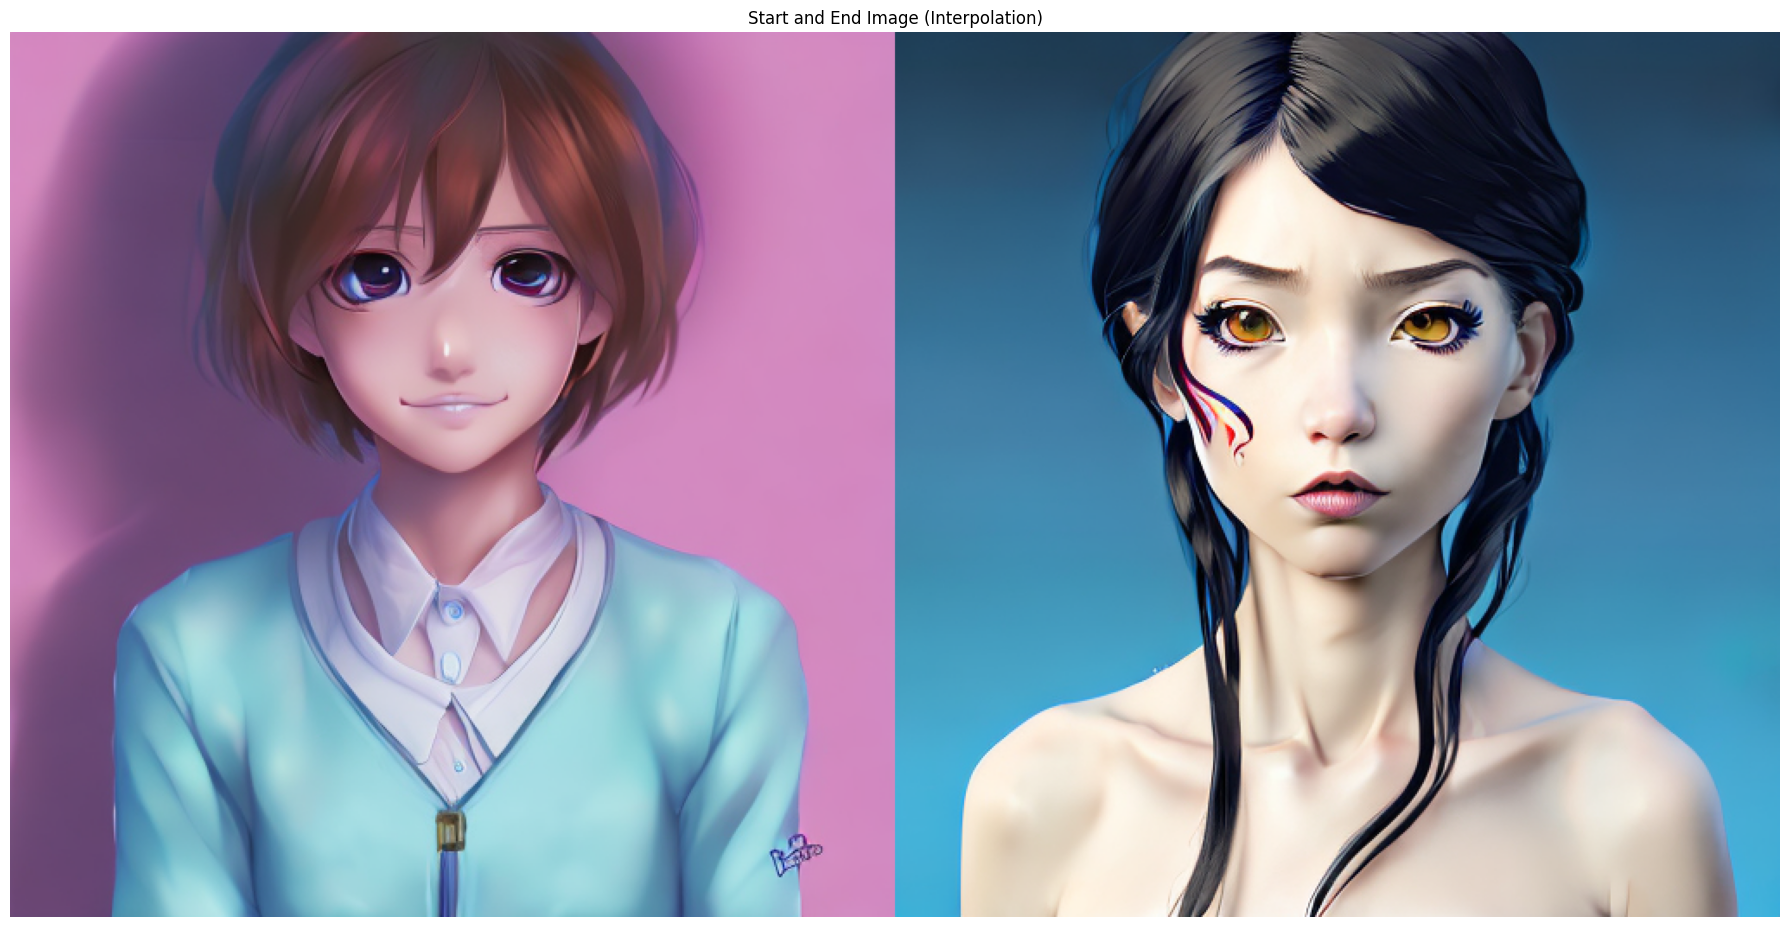

In [5]:
start_prompt = "portrait of Sayori from DDLC, detailed facial features, optimistic colors, bright eyes, warm smile, delicate, by artgerm and WLOP"
start_seed = 3167288399
start  = gen.generate(GeneratorConfig(prompt=start_prompt, seed=start_seed))
start_image = start["images"][0]

end_prompt = "a portrait of a beautiful scythe, art by ilya kuvshinov and wlop and and josan gonzalez, roy lichtenstein, shikanosuke yagaki, mitsumayo, reivaille, digital art, highly detailed, intricate, sharp focus, trending on artstation hq, deviantart, pinterest, unreal engine 5, 4 k uhd image "
end_seed = 2107144638
end  = gen.generate(GeneratorConfig(prompt=end_prompt, seed=2107144638, guidance_scale=18))
end_image = end["images"][0]  

plot_images(stack_images([start_image, end_image]), title="Start and End Image (Interpolation)")

In [6]:
prompt_config = GeneratorConfig(
    prompt=start_prompt,  
    num_inference_steps=40,  
    seed=3167288399,
    strength=1,
    filter_nsfw=False, 
    application={
            "type": "interpolate",
            "config": {"num_steps": 32,  
            "image": {"start": start_image, "end":end_image} ,
            "prompt": {"start": start_prompt, "end": end_prompt}
            }
})
face_results = gen.generate(prompt_config) 

100%|███████████████████████████| 32/32 [01:22<00:00,  2.58s/it]


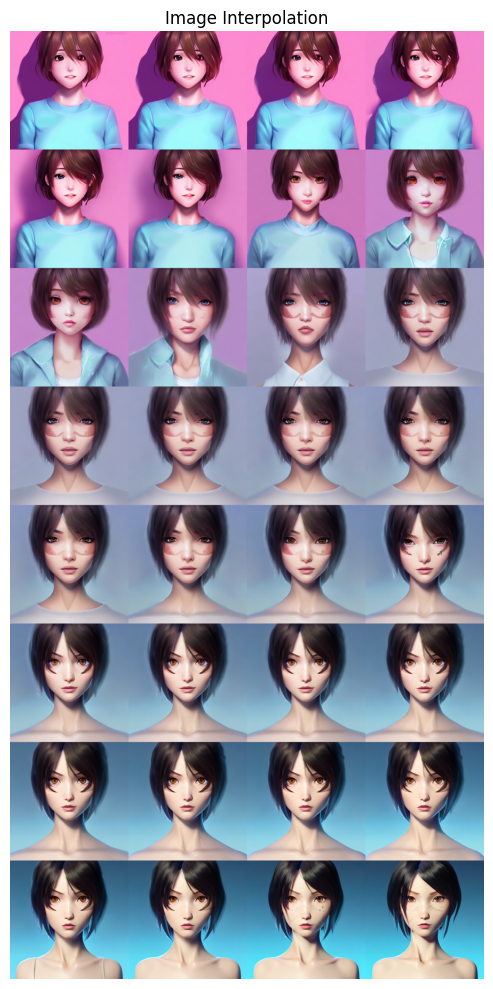

In [13]:
stacked_face_results = process_results(face_results, width=1024, num_cols=4)
plot_images(stacked_face_results, title="Image Interpolation")
# stacked_results.save("../docs/images/image_interpolation.png")

100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.57s/it]


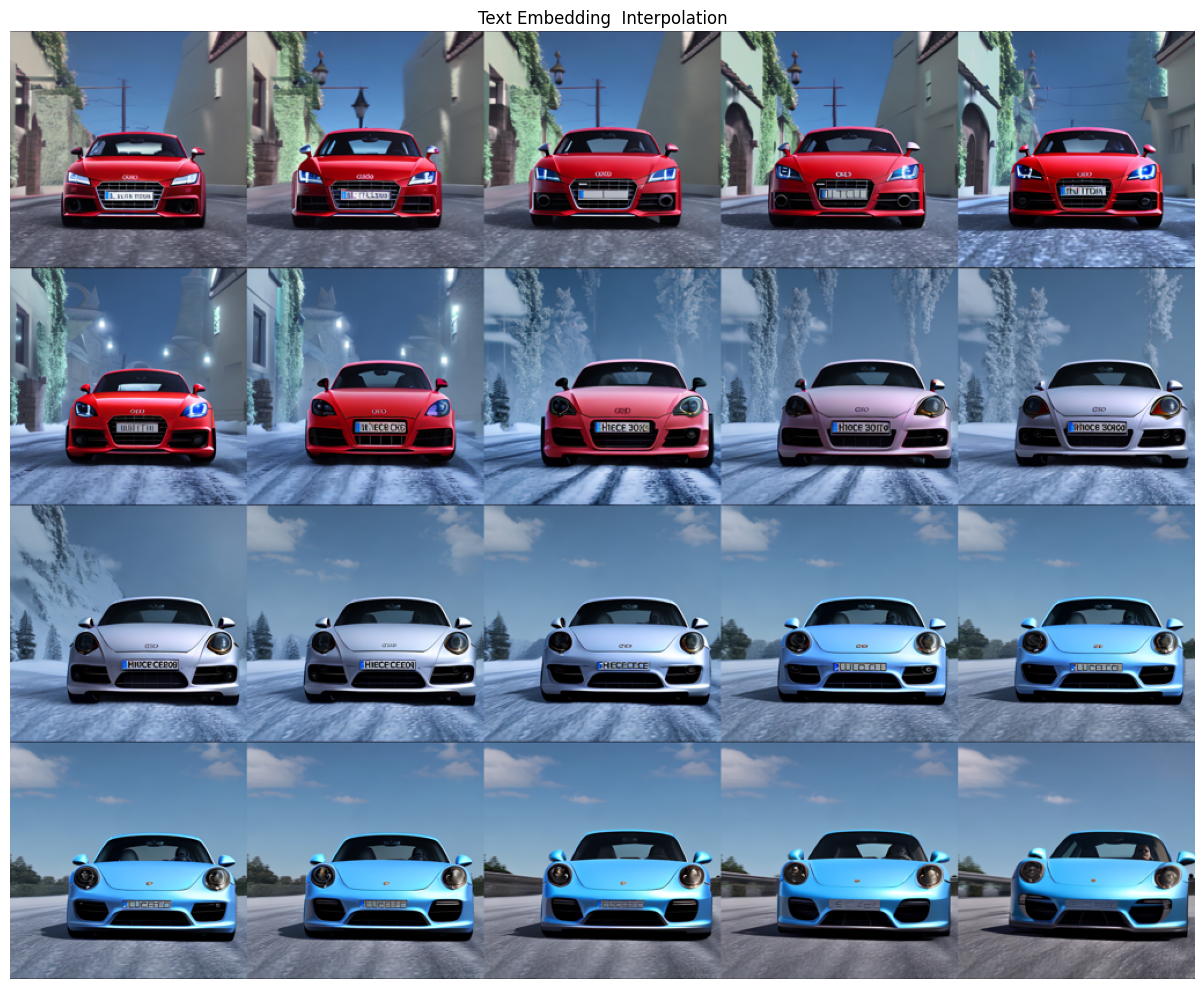

In [8]:
text_interpolation_config = GeneratorConfig(
    prompt="",
    num_images=1,
    num_inference_steps=40, 
    seed = 100034,
    filter_nsfw = False,
    application={
        "type": "interpolate",
        "config": {"num_steps": 20,  
        "prompt": {"start": "red (audi TT car) front view modern disney style ", "end": "blue (porsche carrera gt ) front view  modern disney style "}
        }
    })
text_interpolation_results = gen.generate(text_interpolation_config)  
stacked_text_interpolation_results = process_results(text_interpolation_results)
plot_images(stacked_text_interpolation_results, title="Text Embedding  Interpolation")
